# Example to perform causal discovery using RCD with bootstrap and imputation on data with discrete variables

This notebook explains how to perform causal discovery with multiple imputations on data with missing values when exogenous, endogenous, and sink variables are assumed, as well as when discrete ordinal variables are included in the exogenous and sink variables.  

Most algorithms implemented in lingam package can't be applied to data containing discrete variables. However, when discrete variables are included in exogenous or sink variables, it is possible to perform causal discovery by incorporating the ideas described in this notebook.  

Hereinafter, `NaN` or `nan` represents missing values.

**Note:** If your dataset does not contain missing values, please refer to the following example instead:  
[Example to perform causal discovery on data with discrete variables](https://github.com/cdt15/lingam/blob/master/examples/Example_to_perform_causal_discovery_on_data_with_discrete_variables.ipynb)


## Preparation

### Import packages

In [1]:
import os
import requests
from collections import deque

import numpy as np
import pandas as pd
import semopy
from scipy.special import expit

from lingam import BootstrapResult, MultiGroupRCD
from lingam.utils import remove_effect, calculate_total_effect, make_dot, make_prior_knowledge, print_dagc, print_causal_directions
from lingam.tools import BaseMultipleImputation, BaseMultiGroupCDModel
from lingam.tools import bootstrap_with_imputation

import matplotlib.pyplot as plt
import graphviz as gv
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Using the following package versions:
- numpy: 1.26.4
- pandas: 2.3.3
- scipy: 1.10.1
- semopy: 2.3.11
- lingam: 1.11.0
- scikit-learn: 1.7.2
- matplotlib: 3.10.7
- graphviz: 0.21

### Config

In [2]:
np.random.seed(0)

# number of multiple imputations
n_repeats = 5

### Download source code

To run this notebook, you need to download and set up the source code for [pruning_missing_data](https://github.com/cdt15/pruning_missing_data). The source code can be downloaded and imported by executing the code below, but the R environment, along with the mice and miselect packages, must be installed manually.

In [3]:
def _get_code(url, dirname="."):
    res = requests.get(url)
    if res.status_code != 200:
        raise RuntimeError("Couldn't get a source code.")
    
    with open(dirname + os.sep + url.split("/")[-1], "w", encoding="utf-8") as f:
        f.write(res.text)


# destinaiton of downloaded source code
dirname = "pruning_missing_data"
if not os.path.isdir(dirname):
    os.mkdir(dirname)

    # download required source code
    _get_code("https://raw.githubusercontent.com/cdt15/pruning_missing_data/refs/heads/main/pruning_missing_data/__init__.py", dirname=dirname)
    _get_code("https://raw.githubusercontent.com/cdt15/pruning_missing_data/refs/heads/main/pruning_missing_data/_estimate_adj_matrix_for_stacked_imputed_datasets.py", dirname=dirname)
    _get_code("https://raw.githubusercontent.com/cdt15/pruning_missing_data/refs/heads/main/pruning_missing_data/_impute_by_mice.py", dirname=dirname)
    _get_code("https://raw.githubusercontent.com/cdt15/pruning_missing_data/refs/heads/main/pruning_missing_data/estimate_adj_matrix_for_stacked_imputed_datasets.r", dirname=dirname)
    _get_code("https://raw.githubusercontent.com/cdt15/pruning_missing_data/refs/heads/main/pruning_missing_data/impute_by_mice.r", dirname=dirname)

from pruning_missing_data import impute_by_mice, estimate_adj_matrix_for_stacked_imputed_datasets

# check that dounwloaded source code works properly
try:
    X = np.zeros((2, 10))
    X[0] = np.random.uniform(size=10)
    X[1] = (0.5 >= np.random.uniform(0, 1, size=10)).astype(int)
    X = pd.DataFrame(X).T
    missing_pos = []
    for i, prop in enumerate([0.5, 0.5]):
        mask = np.random.uniform(0, 1, size=len(X))
        missing_pos.append(mask < prop)
    missing_pos = np.array(missing_pos).T
    X[missing_pos] = np.nan
    X_list = impute_by_mice(X, n_imputations=3, is_discrete=[False, True], seed=42)
except:
    raise RuntimeError("Check that the R and mice packages are installed and that the path to the Rscript is set correctly.")


## Test data

### Adjacency matrix

In [4]:
m = np.array([
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    [0.0000, 0.5215, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    [0.0000, 0.8635, 0.2685, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6425],
    [0.5205, 0.0000, 0.0000, 0.2135, 0.4555, 0.0000, 0.0000, 0.0000, 0.0000],
    [0.0000, 0.0000, 0.0000, 0.9800, 0.0000, 0.0000, 0.0000, 0.0000, 0.7325],
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4415, 0.6925, 0.0000, 0.0000],
    [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
])

names = [f"x{i + 1}" for i in range(len(m))]
m = pd.DataFrame(m, columns=names, index=names)

m

,x1,x2,x3,x4,x5,x6,x7,x8,x9
x1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
x2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
x3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
x4,0.0000,0.5215,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
x5,0.0000,0.8635,0.2685,0.0000,0.0000,0.0000,0.0000,0.0,0.6425
x6,0.5205,0.0000,0.0000,0.2135,0.4555,0.0000,0.0000,0.0,0.0000
x7,0.0000,0.0000,0.0000,0.9800,0.0000,0.0000,0.0000,0.0,0.7325
x8,0.0000,0.0000,0.0000,0.0000,0.0000,0.4415,0.6925,0.0,0.0000
x9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000


This adjacency matrix is drawn as a following causal graph:

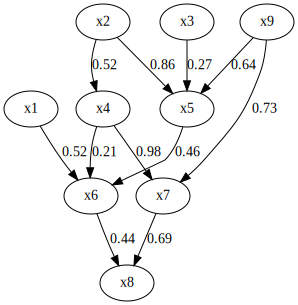

In [5]:
dot = make_dot(m, lower_limit=0, labels=m.columns.tolist())
dot.render(format="svg")
display(dot)

### Generate test data

We generate a test dataset based on a predefined adjacency matrix. In this dataset, variables x1 and x8 are generated as discrete variables taking values 0 or 1. Additionally, we include one latent (unobserved) variable x9 with hidden causal effects.

In [6]:
# settings
n_sample = 1000
discrete_indices = [0, 7]

# initialize
X = np.zeros((len(m), n_sample))

# generate test data according to m
for i in range(len(m)):
    if i not in discrete_indices:
        X[i] = m.iloc[i] @ X + np.random.uniform(-1.732, 1.732, size=n_sample)
    else:
        X[i] = (expit(m.iloc[i] @ X) >= np.random.uniform(0, 1, size=n_sample)).astype(int)
X = pd.DataFrame(X.T, columns=names)

# convert types of continuous variables to float, types of discrete variables to int
dtypes = {}
for i, name in enumerate(names):
    dtypes[name] = int if i in discrete_indices else float
X = X.astype(dtypes)

X = X.iloc[:, :-1]

`impute_by_mice` imputes given data with missing values. The following code generates data with missing values.

In [7]:
def generate_missing_pos(X, prop_missing):
    missing_pos = []
    for i, prop in enumerate(prop_missing):
        mask = np.random.uniform(0, 1, size=len(X))
        missing_pos.append(mask < prop)
    missing_pos = np.array(missing_pos).T
    
    return missing_pos

prop_missing = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
missing_pos = generate_missing_pos(X, prop_missing)

# keep true values
true_values = X.copy()
true_values[~missing_pos] = np.nan

X[missing_pos] = np.nan

Actual proportions of missing values are as follows:

In [8]:
np.isnan(X).sum(axis=0) / len(X)

x1    0.098
x2    0.098
x3    0.099
x4    0.109
x5    0.115
x6    0.110
x7    0.107
x8    0.114
dtype: float64

Histograms of test data are as follows:

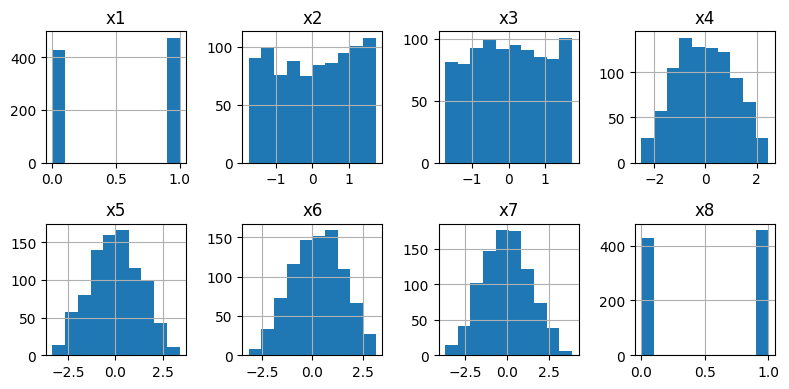

In [9]:
X.hist(layout=(2, 4), figsize=(8, 4))
plt.tight_layout()
plt.show()

Types of test data are as follows:

In [10]:
X.dtypes

x1    float64
x2    float64
x3    float64
x4    float64
x5    float64
x6    float64
x7    float64
x8    float64
dtype: object

## Analysis

This chapter demonstrates how to perform causal discovery on data that includes both discrete variables and missing values.

### Classify test data variables into three subsets  

We classify test data variables into three subsets: exogenous variables, endogenous variables, and sink variables.  
Additionally, we create a Boolean list that indicates which variables are discrete.

In [11]:
exog_var_names = ["x1", "x2", "x3"]
endog_var_names = ["x4", "x5", "x6", "x7"]
sink_var_name = "x8"

exog_indices = [X.columns.tolist().index(v) for v in exog_var_names]
endog_indices = [X.columns.tolist().index(v) for v in endog_var_names]
sink_index = X.columns.tolist().index(sink_var_name)

is_discrete = [True if i in discrete_indices else False for i in range(len(X.columns))]
is_discrete

[True, False, False, False, False, False, False, True]

The causal graph is as follows:

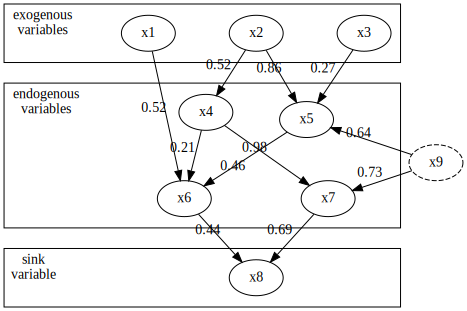

In [12]:
def display_graph(m, exog_var_names, endog_var_names, sink_var_name):
    g = gv.Digraph(engine="neato", graph_attr={"splines":"true"})

    cluster_names = ["exogenous", "endogenous", "sink"]

    node_kws = {
        "x1": {"pos": "0,0!"},
        "x2": {"pos": "1.5,0!"},
        "x3": {"pos": "3.0,0!"},
        "x4": {"pos": "0.8,-1.1!"},
        "x5": {"pos": "2.2,-1.2!"},
        "x6": {"pos": "0.5,-2.3!"},
        "x7": {"pos": "2.5,-2.3!"},
        "x8": {"pos": "1.5,-3.4!"},
        "x9": {"pos": "4.0,-1.8!", "style": "dashed"}  # latent variable
    }

    dummy_node_kws = {
        "exogenous": [
            {"pos":"-2,0.4!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
            {"pos":"3.5,-0.4!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
        ],
        "endogenous": [
            {"pos":"-2,-0.7!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
            {"pos":"3.5,-2.7!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
        ],
        "sink": [
            {"pos":"-2,-3.0!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
            {"pos":"3.5,-3.8!", "style":"invis", "fixedsize":"true", "width":"0", "height":"0"},
        ]
    }

    # add nodes
    for cluster_name, var_names in zip(cluster_names, [exog_var_names, endog_var_names, [sink_var_name]]):
        # make subgraph
        with g.subgraph(name=f"cluster_{cluster_name}", graph_attr={"margin":"4,4!"}) as sub:
            for var_name in var_names:
                kw = {} if var_name not in node_kws.keys() else node_kws[var_name]
                sub.node(var_name, var_name, **kw)
            s = "" if cluster_name == "sink" else "s"
            sub.attr(label=f"{cluster_name}\nvariable" + s, labeljust="l")

            # dummies
            sub.node(cluster_name + "_lu", "", **dummy_node_kws[cluster_name][0])
            sub.node(cluster_name + "_rl", "", **dummy_node_kws[cluster_name][1])

    # add edges
    for to_name, coefs in m.iterrows():
        for from_name, coef in coefs.items():
            if np.isclose(coef, 0):
                continue

            g.edge(from_name, to_name, label=f"{coef:.2f}")
            
    g.node("x9", "x9", **node_kws["x9"])
    display(g)
    g.render(format="svg")

display_graph(m, exog_var_names, endog_var_names, sink_var_name)

### Perform causal discovery

we apply multiple imputation using `impute_by_mice` to fill in the missing values in the test data $X$.

In [13]:
X_list = impute_by_mice(X, n_imputations=n_repeats, is_discrete=is_discrete, seed=0)

A causal discovery is performed with test data X and three subsets of variable names to analyze a causal relation of endogenous variables and sink variable. We remove effects of exogenous variables from test data X.

In [14]:
# remove effects of exogenous variables from X by regression
X_removed_exog_list = [remove_effect(X_, exog_indices) for X_ in X_list]

We perform causal discovery using the test data after removing the influence of exogenous variables.
Using the endogenous variables with the effects of exogenous variables removed, we estimate the causal ordering by applying the `MultiGroupRCD` method, which is designed for causal discovery across multiple datasets.

In [15]:
X_endog_list = [arr[:, endog_indices] for arr in X_removed_exog_list]
cd_model = MultiGroupRCD()
cd_model.fit(X_endog_list)

**Construct the overall causal order**  
   We define the global causal order by arranging variables in the following sequence:  
   exogenous variables → endogenous variables (in topological order) → sink variable.  
   No specific causal order is assumed among exogenous variables, and the sink variable is always placed at the end.

In [16]:
# unction to create a causal order (topological sort) from an ancestors list
def ancestors_list_to_causal_order(ancestors_list):
    n = len(ancestors_list)
    ancestors_list_copy = [set(parents) for parents in ancestors_list]
    indegree = [len(parents) for parents in ancestors_list_copy]
    order = []
    queue = deque([i for i, deg in enumerate(indegree) if deg == 0])
    while queue:
        v = queue.popleft()
        order.append(v)
        for i in range(n):
            if v in ancestors_list_copy[i]:
                ancestors_list_copy[i].remove(v)
                indegree[i] -= 1
                if indegree[i] == 0:
                    queue.append(i)
    if len(order) != n:
        print('Warning: The graph may not be a DAG (cycle detected)')
    return order

endog_causal_order = ancestors_list_to_causal_order(cd_model.ancestors_list_)
causal_order = exog_indices + [endog_indices[i] for i in endog_causal_order] + [sink_index]
causal_order

[0, 1, 2, 3, 4, 6, 5, 7]

### Setting Prior Knowledge
Prior knowledge is defined for causal structure learning:
* Exogenous variables: Variables that are not influenced by any other variables.
* Sink variable: A variable located at the output end of the causal graph.
* No paths: Explicitly specified pairs of variables between which no causal relationship is assumed.

In [17]:
n_samples, n_features = X.shape

no_paths = []
for sink_index_ in [sink_index]:
    for exog_index_ in exog_indices:
        no_paths.append((exog_index_, sink_index_))
        
prior_knowledge = make_prior_knowledge(
    n_variables=n_features,
    exogenous_variables=exog_indices,
    sink_variables=[sink_index],
    no_paths=no_paths
)
pk = pd.DataFrame(prior_knowledge, index=X.columns.tolist(), columns=X.columns.tolist())
pk

,x1,x2,x3,x4,x5,x6,x7,x8
x1,-1,0,0,0,0,0,0,0
x2,0,-1,0,0,0,0,0,0
x3,0,0,-1,0,0,0,0,0
x4,-1,-1,-1,-1,-1,-1,-1,0
x5,-1,-1,-1,-1,-1,-1,-1,0
x6,-1,-1,-1,-1,-1,-1,-1,0
x7,-1,-1,-1,-1,-1,-1,-1,0
x8,0,0,0,-1,-1,-1,-1,-1


## Estimate adjacency matrix

To estimate a single adjacency matrix from the results of multiple imputation, we use `estimate_adj_matrix_for_stacked_imputed_datasets`. A common pruning is then applied using `saenet` to construct the final overall adjacency matrix.

In [18]:
weights = 1 - np.sum(np.isnan(X), axis=1) / X.shape[1]

adj_mat = estimate_adj_matrix_for_stacked_imputed_datasets(
    X_list,
    causal_order,
    is_discrete=is_discrete,
    ad_weight_type="min",
    weights=weights,
    prior_knowledge=prior_knowledge,
    seed=0
)
pd.DataFrame(adj_mat, index=X.columns.tolist(), columns=X.columns.tolist())

,x1,x2,x3,x4,x5,x6,x7,x8
x1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
x2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
x3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
x4,0.052661,0.501606,0.062572,0.000000,0.000000,0.000000,0.000000,0.0
x5,-0.021258,0.833134,0.211747,0.000000,0.000000,0.000000,0.000000,0.0
x6,0.508674,0.000000,0.000000,0.196214,0.424244,0.000000,0.000000,0.0
x7,0.007446,0.018325,0.012870,0.929591,-0.036937,0.000000,0.000000,0.0
x8,0.000000,0.000000,0.000000,0.124654,0.000000,0.349318,0.525117,0.0


We assume hidden common causes between exogenous variables.

In [19]:
for from_ in exog_indices:
    for to_ in exog_indices:
        if to_ != from_:
            adj_mat[to_, from_] = np.nan
pd.DataFrame(adj_mat, index=X.columns.tolist(), columns=X.columns.tolist())

,x1,x2,x3,x4,x5,x6,x7,x8
x1,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0
x2,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.0
x3,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
x4,0.052661,0.501606,0.062572,0.000000,0.000000,0.000000,0.000000,0.0
x5,-0.021258,0.833134,0.211747,0.000000,0.000000,0.000000,0.000000,0.0
x6,0.508674,0.000000,0.000000,0.196214,0.424244,0.000000,0.000000,0.0
x7,0.007446,0.018325,0.012870,0.929591,-0.036937,0.000000,0.000000,0.0
x8,0.000000,0.000000,0.000000,0.124654,0.000000,0.349318,0.525117,0.0


We incorporate the hidden common causes estimated by MultiGroupRCD into the endogenous variables.

In [20]:
adj_mat[np.ix_(endog_indices, endog_indices)] = np.where(
    np.isnan(cd_model.adjacency_matrices_[0]),
    np.nan,
    adj_mat[np.ix_(endog_indices, endog_indices)]
    )
pd.DataFrame(adj_mat, index=X.columns.tolist(), columns=X.columns.tolist())


,x1,x2,x3,x4,x5,x6,x7,x8
x1,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.0
x2,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.0
x3,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
x4,0.052661,0.501606,0.062572,0.000000,0.000000,NaN,0.000000,0.0
x5,-0.021258,0.833134,0.211747,0.000000,0.000000,0.000000,NaN,0.0
x6,0.508674,0.000000,0.000000,NaN,0.424244,0.000000,0.000000,0.0
x7,0.007446,0.018325,0.012870,0.929591,NaN,0.000000,0.000000,0.0
x8,0.000000,0.000000,0.000000,0.124654,0.000000,0.349318,0.525117,0.0


### Visualize a result

The causal graph is as follows:

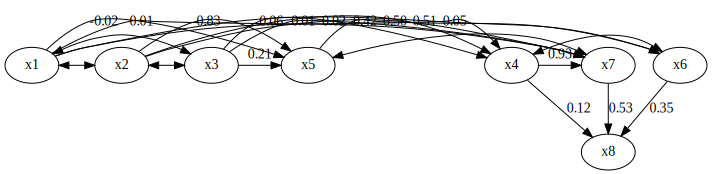

In [21]:
dot = make_dot(adj_mat, labels=X.columns.tolist(), lower_limit=0.00)
dot.render(format="svg")
dot

### Evaluation by fitting indices

The estimated results are considered as a SEM model and the fitting indices is calculated.

In [22]:
def calc_fit_indices(B, X, exog_var_names, is_discrete):
    """ calculate fitting indices with adjacency matrix B and data X """
    
    B = B.copy().drop(exog_var_names, axis=0)
    
    desc = ""
    
    # equations
    for name, row in B.iterrows():
        var_model = []
        
        for name2, coef in row.items():
            if np.isclose(coef, 0):
                continue
            var_model.append(f"{name2}")
        
        if len(var_model) == 0:
            continue
        
        var_model = f"{name} ~ " + " + ".join(var_model) + "\n"
        desc += var_model
    
    # covariance between exogenous variables
    for exog_var_name in exog_var_names:
        desc += exog_var_name + " ~~ " + " + ".join(list(set(exog_var_names) - {exog_var_name})) + "\n"
    
    # constraints
    desc += "DEFINE(ordinal) " + " ".join(X.columns[is_discrete])
    
    m = semopy.Model(desc)
    m.fit(X)
    stats = semopy.calc_stats(m)
    
    return stats


In [23]:
def boxplot_fit_indices_summary(fit_indices_summary):
    # Draw box plots in a grid layout with 4 columns
    columns = fit_indices_summary.columns
    num_columns = len(columns)
    num_rows = round(num_columns / 7)
    
    fig, axes = plt.subplots(num_rows, 7, figsize=(10, 5))
    axes = axes.flatten()
    
    for i, column in enumerate(columns):
        axes[i].boxplot(fit_indices_summary[column])
        axes[i].set_title(f"{column}", fontsize=10)
        axes[i].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
        axes[i].tick_params(axis="y", labelsize=10)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

The fitting indices is calculated across the datasets generated by each iteration of multiple imputation.

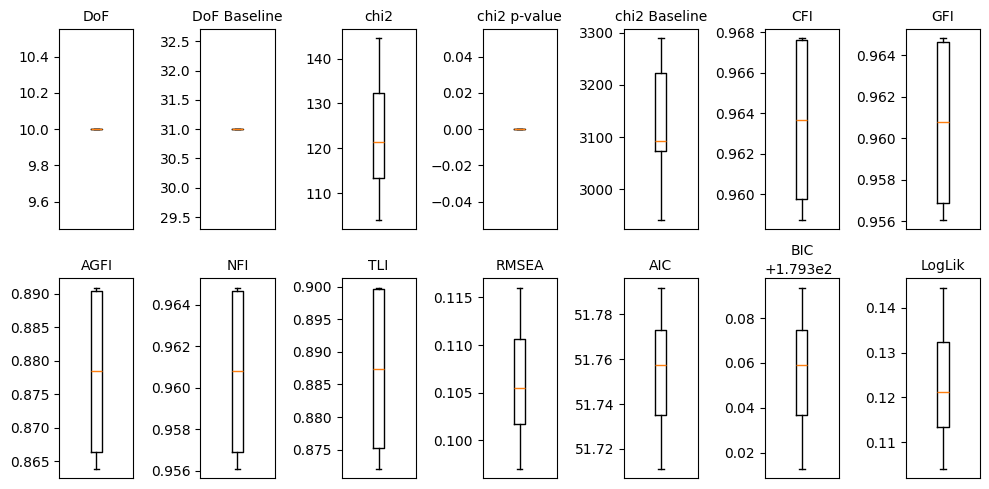

In [24]:
fit_indices_list = []
for X_ in X_list:
    adj = np.nan_to_num(adj_mat, nan=0.0)
    df_adj = pd.DataFrame(adj, index=X.columns, columns=X.columns)
    df_X = pd.DataFrame(X_, columns=X.columns)
    fit_indices = calc_fit_indices(df_adj, df_X, exog_var_names, is_discrete)
    fit_indices_list.append(fit_indices)
    
# concatenate data frames
fit_indices_summary = pd.concat(fit_indices_list)

boxplot_fit_indices_summary(fit_indices_summary)


## Analysis with bootstrapping

To execute the following code, version 1.9.1 or later lingam package is required.  

lingam.tools.bootstrap_with_imputation is a function used to perform causal discovery on datasets that contain missing values.

This section describes how to set `impute_by_mice` to `bootstrap_with_imputation` as the alternative imputer, and how to use `estimate_adj_matrix_for_stacked_imputed_datasets` as an alternative causal discovery model.

In [25]:
class CustomizedMultipleImputationWithDV(BaseMultipleImputation):
    """ perform the multiple imputation by mice"""
    
    def __init__(self, n_imputations=10, maxit=10, is_discrete=None, seed=None):
        """
        n_imputations : int, optional (defualt=10)
            The number of multiple imputations.
        maxit : int, optional (default=10)
            The number of iterations.
        is_discrete : array-like of shape (n_features, ), optional (default=None)
            ``is_discrete[i]`` specifies whether the i-th feature is discrete or not.
            All features are considered continuous if ``is_discrete`` is None.
        seed : int, optional (default=None)
            The seed for random numbers.
        """
        self._n_imputations = n_imputations
        self._maxit = maxit
        self._is_discrete = is_discrete
        self._seed = seed
        
    def fit_transform(self, X):
        X_list = impute_by_mice(X, n_imputations=self._n_imputations, maxit=self._maxit, is_discrete=self._is_discrete, seed=self._seed)
        return X_list

In [26]:
class CustomizedMGCDModelWithDV(BaseMultiGroupCDModel):
    """ perform the causal discovery on the multigroup dataset and
        prune estimated adjacency matrices assuming a common pruning pattern. 
    """
    
    def __init__(
        self,
        exog_indices,
        endog_indices,
        sink_index,
        is_discrete=None,
        ad_weight_type="min",
        seed=None
        ):
        """
        exog_indices : list of int
            List of index of exogenous variables.
        endog_indices : list of int
            List of index of endogenous variables.
        sink_index : int
            Index of the sink variable.
        is_discrete : array-like of shape (n_features, ), optional (default=None)
            ``is_discrete[i]`` specifies whether the i-th feature is discrete or not.
            All features are considered continuous if ``is_discrete`` is None.
        ad_weight_type : str, "min" or "1se", optional (default="min")
            The name of the method to decide the adaptive weights.
        prior_knowledge : array-like, shape (n_features, n_features), optional (default=None)
            Prior knowledge used for causal discovery, where ``n_features`` is the number of features.
        apply_prior_knowledge_softly : boolean, optional (default=False)
            If True, apply prior knowledge softly.
        seed : int, optional (default=None)
            The seed for random numbers.
        """
        self._exog_indices = exog_indices
        self._endog_indices = endog_indices
        self._sink_index = sink_index
        self._is_discrete = is_discrete
        self._ad_weight_type = ad_weight_type
        self._seed = seed
        
        self._cd_model = MultiGroupRCD()

    
    def before_imputation(self, X):
        self._weights = 1 - np.sum(np.isnan(X), axis=1) / X.shape[1]

    def fit(self, X_list):
        # remove effects of exogenous variables from X by regression
        X_removed_exog_list = [remove_effect(X_, exog_indices) for X_ in X_list]

        # A list of datasets of endogenous variables with the effects of exogenous variables removed
        X_endog_list = [arr[:, self._endog_indices] for arr in X_removed_exog_list]

        # Causal discovery among endogenous variables after removing the effects of exogenous variables
        self._cd_model.fit(X_endog_list)
        endog_causal_order = ancestors_list_to_causal_order(self._cd_model.ancestors_list_)

        # Overall causal order
        causal_order = self._exog_indices + [self._endog_indices[i] for i in endog_causal_order] + [self._sink_index]
        
        # make one adjacency matrix
        if self._seed == None:
            self._seed = int(np.random.default_rng().integers(0, 1e+4))

        # There is no causal path from exogenous variables to sink variables
        no_paths = [(exog_index_, self._sink_index) for exog_index_ in self._exog_indices]
    
        prior_knowledge = make_prior_knowledge(
            n_variables=len(causal_order),
            exogenous_variables=self._exog_indices,
            sink_variables=[self._sink_index],
            no_paths=no_paths
        )

        adj_mat = estimate_adj_matrix_for_stacked_imputed_datasets(
            X_list,
            causal_order,
            is_discrete=self._is_discrete,
            ad_weight_type=self._ad_weight_type,
            weights=self._weights,
            prior_knowledge=prior_knowledge,
            seed=self._seed
        )

        # Assume the existence of unobserved common causes among exogenous variables
        for from_ in self._exog_indices:
            for to_ in self._exog_indices:
                if to_ != from_:
                    adj_mat[to_, from_] = np.nan
                    
        adj_mat[np.ix_(self._endog_indices, self._endog_indices)] = np.where(
            np.isnan(self._cd_model.adjacency_matrices_[0]),
            np.nan,
            adj_mat[np.ix_(self._endog_indices, self._endog_indices)]
            )
        
        return causal_order, adj_mat

`bootstrap_with_imputation` is performed to obtain estimation results.

In [27]:
# number of bootstraps
n_sampling = 5

# create instances for multiple imputation and causal discovery
imp = CustomizedMultipleImputationWithDV(n_imputations=n_repeats, is_discrete=is_discrete, seed=0)
cd_model = CustomizedMGCDModelWithDV(exog_indices, endog_indices, sink_index, is_discrete=is_discrete, seed=0)

# send instances
result = bootstrap_with_imputation(X, n_sampling, n_repeats=n_repeats, imp=imp, cd_model=cd_model, random_state=0)

causal_orders, adj_list, resampled_indices, imputation_results = result

The fitting indices are calculated across all datasets generated by each combination of bootstrap iterations and multiple imputations.

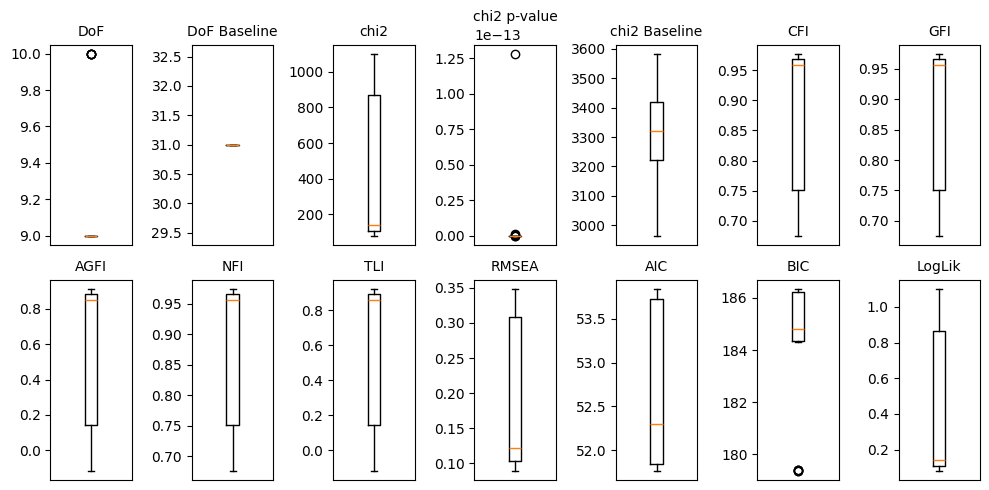

In [28]:
fit_indices_list = []
for adj_, resampled_index_, resampled_imputation_result_ in zip(adj_list, resampled_indices, imputation_results):
    filled_adj_ = np.nan_to_num(adj_, nan=0.0)
    df_adj = pd.DataFrame(filled_adj_, index=X.columns, columns=X.columns)
    resampled_sample_ = X.iloc[resampled_index_]
    for imputation_result_ in resampled_imputation_result_:
        imputed_sample = resampled_sample_.where(pd.isna(imputation_result_), imputation_result_)
        fit_indices = calc_fit_indices(df_adj, imputed_sample, exog_var_names, is_discrete)
        fit_indices_list.append(fit_indices)
    
# concatenate data frames
fit_indices_summary = pd.concat(fit_indices_list)

boxplot_fit_indices_summary(fit_indices_summary)


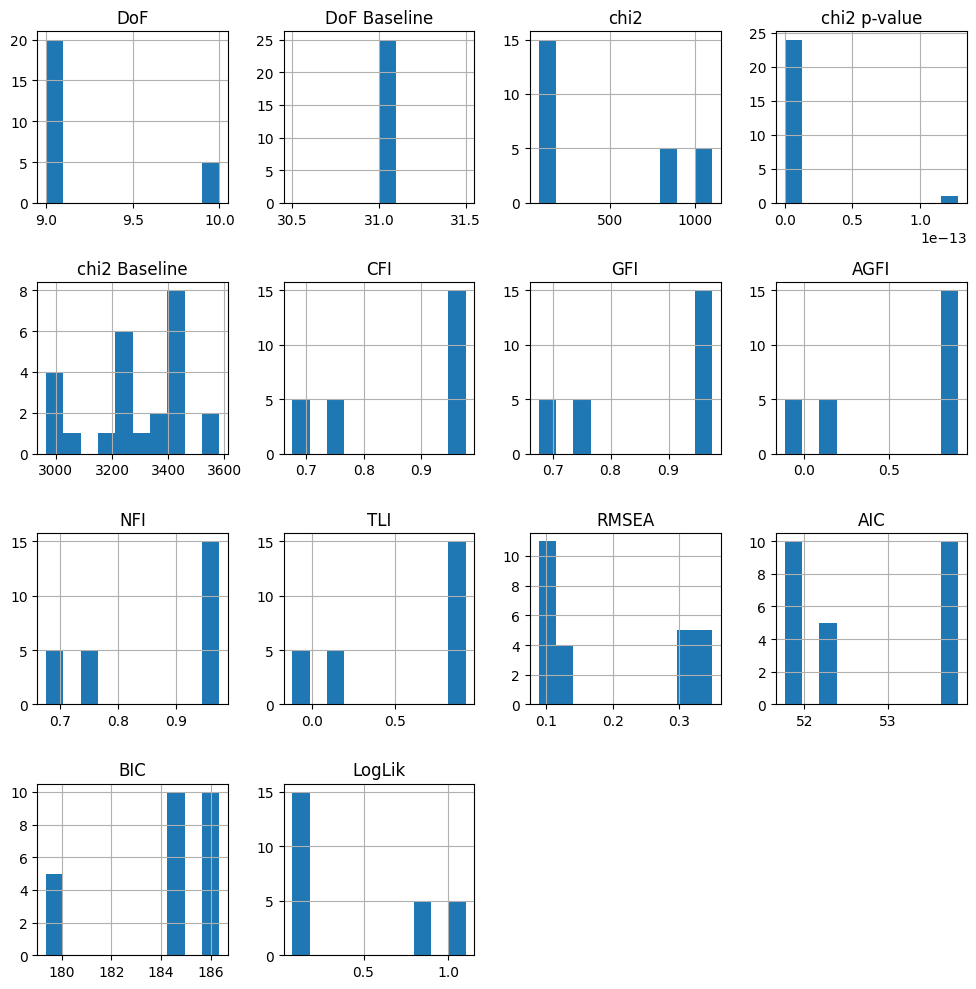

In [29]:
fit_indices_summary.hist(layout=(4, 4), figsize=(10, 10))
plt.tight_layout()
plt.show()

`n_sampling` causal orders and (`n_sampling` * `n_repeats`) adjacency matrices are estimated.

In [30]:
# (n_sampling, n_features, n_features)
adj_list.shape

(5, 8, 8)

The `adj_list` will hold the bootstrap results of `n_sampling` times. To visualize the results of the bootstrap, execute the following code.

For more information on `lingam.bootstrap.BootstrapResult`, check the `lingam` [manual](https://lingam.readthedocs.io/en/stable/reference/bootstrap.html) and [samples](https://github.com/cdt15/lingam/blob/master/lingam/bootstrap.py).

In [31]:
# calculate total effect
total_effect = np.zeros(adj_list.shape)
for i, (causal_order, adj) in enumerate(zip(causal_orders, adj_list)):
    for j, from_ in enumerate(causal_order):
        for to in causal_order[j + 1 :]:
            eff = calculate_total_effect(adj, from_, to)
            total_effect[i, to, from_] = eff

bs_result = BootstrapResult(adj_list, total_effect)

### Confirm results of the bootstrapping

For more information on verifying bootstrap results, refer to [this notebook](https://github.com/cdt15/lingam/blob/master/examples/Bootstrap.ipynb).

### Causal Directions

In [32]:
# variable names of an estimated adjacency matrix
var_names = X.columns.tolist()

cdc = bs_result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_causal_directions(cdc, n_sampling, labels=var_names)

x4 <--- x1 (b>0) (100.0%)
x8 <--- x4 (b>0) (100.0%)
x8 <--- x6 (b>0) (100.0%)
x6 <--- x1 (b>0) (100.0%)
x5 <--- x3 (b>0) (100.0%)
x8 <--- x7 (b>0) (100.0%)
x4 <--- x3 (b>0) (100.0%)
x4 <--- x2 (b>0) (100.0%)


### Directed Acyclic Graphs

In [33]:
dagc = bs_result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_dagc(dagc, n_sampling, labels=var_names)

DAG[0]: 20.0%
	x4 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
	x5 <--- x1 (b<0)
	x5 <--- x2 (b>0)
	x5 <--- x3 (b>0)
	x5 <--- x7 (b<0)
	x6 <--- x1 (b>0)
	x6 <--- x5 (b>0)
	x7 <--- x1 (b>0)
	x7 <--- x3 (b>0)
	x7 <--- x4 (b>0)
	x8 <--- x4 (b>0)
	x8 <--- x5 (b<0)
	x8 <--- x6 (b>0)
	x8 <--- x7 (b>0)
DAG[1]: 20.0%
	x4 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
	x5 <--- x1 (b<0)
	x5 <--- x2 (b>0)
	x5 <--- x3 (b>0)
	x6 <--- x1 (b>0)
	x6 <--- x3 (b<0)
	x6 <--- x5 (b>0)
	x7 <--- x2 (b<0)
	x7 <--- x3 (b<0)
	x8 <--- x4 (b>0)
	x8 <--- x6 (b>0)
	x8 <--- x7 (b>0)
DAG[2]: 20.0%
	x4 <--- x1 (b>0)
	x4 <--- x2 (b>0)
	x4 <--- x3 (b>0)
	x5 <--- x1 (b<0)
	x5 <--- x2 (b>0)
	x5 <--- x3 (b>0)
	x6 <--- x1 (b>0)
	x6 <--- x3 (b<0)
	x6 <--- x5 (b>0)
	x7 <--- x1 (b>0)
	x7 <--- x2 (b>0)
	x7 <--- x4 (b>0)
	x8 <--- x4 (b>0)
	x8 <--- x5 (b>0)
	x8 <--- x6 (b>0)
	x8 <--- x7 (b>0)


### Bootstrap probability

In [34]:
prob = bs_result.get_probabilities(min_causal_effect=None)
display(pd.DataFrame(prob, index=X.columns, columns=X.columns))

,x1,x2,x3,x4,x5,x6,x7,x8
x1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
x4,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
x5,1.0,1.0,1.0,0.2,0.0,0.0,0.2,0.0
x6,1.0,0.2,0.6,0.2,0.8,0.0,0.0,0.0
x7,0.6,0.6,0.8,0.6,0.4,0.2,0.0,0.0
x8,0.0,0.0,0.0,1.0,0.4,1.0,1.0,0.0


### Total Causal Effects

In [35]:
causal_effects = bs_result.get_total_causal_effects(min_causal_effect=0.01)

df = pd.DataFrame(causal_effects)
df['from'] = df['from'].apply(lambda x : var_names[x])
df['to'] = df['to'].apply(lambda x : var_names[x])
display(df)

,from,to,effect,probability
0,x1,x4,0.097101,1.0
1,x5,x8,0.138897,1.0
2,x4,x8,0.679765,1.0
3,x2,x8,0.352627,1.0
4,x1,x8,0.267967,1.0
5,x2,x7,0.316220,1.0
6,x6,x8,0.360580,1.0
7,x2,x6,0.374823,1.0
8,x7,x8,0.621726,1.0
9,x2,x4,0.496152,1.0


### Bootstrap Probability of Path

In [36]:
from_var_name = "x4"
to_var_name = "x8"
display(Markdown(f"#### {from_var_name}→{to_var_name}"))

path = bs_result.get_paths(var_names.index(from_var_name), var_names.index(to_var_name))
path = pd.DataFrame(path)

path["path"] = path["path"].apply(lambda indices: [var_names[i] for i in indices])

path

#### x4→x8

,path,effect,probability
0,"[x4, x8]",0.102017,1.0
1,"[x4, x7, x8]",0.577873,0.6
2,"[x4, x5, x6, x8]",0.000492,0.2
3,"[x4, x5, x7, x8]",-0.000006,0.2
4,"[x4, x6, x8]",0.071515,0.2
5,"[x4, x7, x5, x6, x8]",-0.005395,0.2
6,"[x4, x7, x5, x8]",0.002839,0.2


### Bootstrap causal graph of the median values
The bootstrap causal graph of the median values is displayed, focusing on edges that represent causal effects appearing with a probability greater than 60%, excluding edges that indicate unobserved confounders.

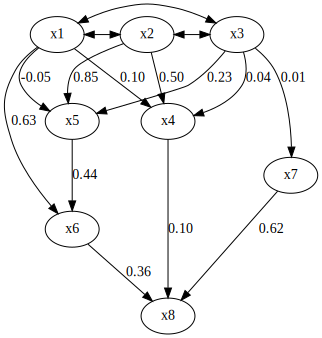

In [37]:
adj = np.zeros(bs_result.adjacency_matrices_[0].shape)
for to in range(len(adj)):
    for from_ in range(len(adj)):
        values = bs_result.adjacency_matrices_[:, to, from_]
        non_zero_values = values[np.abs(values) > 0]
        if non_zero_values.size / values.size > 0.6:
            adj[to, from_] = np.median(non_zero_values)

# Assume the existence of unobserved common causes among exogenous variables
for from_ in exog_indices:
    for to_ in exog_indices:
        if to_ != from_:
            adj[to_, from_] = np.nan
dot = make_dot(adj, lower_limit=0.0, labels=X.columns.tolist())
display(dot)